<a href="https://colab.research.google.com/github/thomasbnr/Detection_depression/blob/main/algorithmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des librairies

In [ ]:
import pandas as pnd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_validate, validation_curve, GridSearchCV

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
tweet = pnd.read_csv('pre_processed_data.csv',delimiter=',', engine='python',encoding="utf-8",on_bad_lines='skip',header=[0],index_col=[0])
tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59207 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   59113 non-null  object
 1   label   59207 non-null  int64 
 2   tokens  58909 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


On remarque que dans la colonne tokens, certaines lignes sont vides, il faut donc les supprimer

In [ ]:
tweet = tweet.dropna(subset=['tokens'], how='any')
tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58909 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   58909 non-null  object
 1   label   58909 non-null  int64 
 2   tokens  58909 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


# Visualisation

Répartition des classes

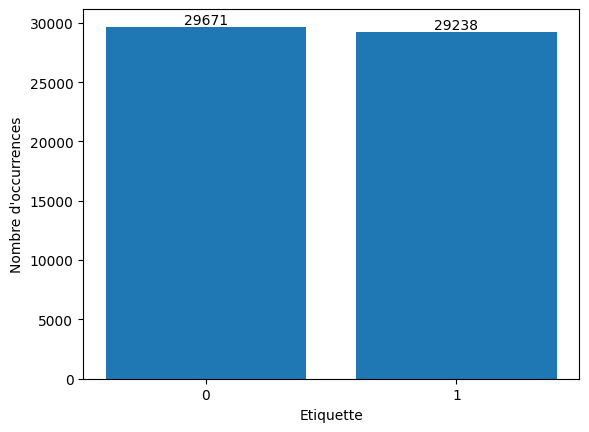

In [ ]:
counts = tweet['label'].value_counts()

labels = counts.index.tolist()
values = counts.values.tolist()

plt.bar(labels, values)

for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xlabel('Etiquette')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(labels, labels)
plt.show()

In [ ]:
"""
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix = tfidf_vectorizer.fit_transform(tweet['tokens'])

X = tfidf_matrix.toarray()
"""

count_vectorizer = CountVectorizer(ngram_range=(1, 1))

bow_matrix = count_vectorizer.fit_transform(tweet['tokens'])
print(bow_matrix)
X = bow_matrix.toarray()

  (0, 26425)	1
  (0, 27003)	1
  (0, 3087)	1
  (0, 35718)	1
  (0, 8912)	1
  (1, 10111)	1
  (1, 3589)	1
  (2, 1623)	1
  (2, 21868)	1
  (2, 41178)	1
  (2, 21869)	1
  (2, 40694)	1
  (2, 2129)	1
  (3, 3815)	1
  (3, 9600)	1
  (3, 10104)	1
  (3, 34845)	1
  (3, 35926)	1
  (3, 2098)	1
  (3, 2491)	1
  (3, 27947)	1
  (3, 2702)	1
  (3, 32423)	1
  (3, 2133)	1
  (4, 21869)	1
  :	:
  (58906, 3775)	1
  (58906, 36962)	1
  (58906, 23905)	1
  (58906, 13114)	1
  (58906, 15141)	1
  (58906, 4033)	1
  (58906, 40555)	1
  (58906, 20563)	1
  (58906, 17317)	1
  (58906, 40231)	1
  (58907, 41178)	1
  (58907, 1375)	1
  (58907, 40716)	1
  (58908, 1375)	1
  (58908, 25133)	1
  (58908, 17358)	1
  (58908, 11305)	1
  (58908, 29066)	1
  (58908, 18566)	1
  (58908, 21614)	1
  (58908, 2097)	1
  (58908, 28510)	1
  (58908, 5436)	1
  (58908, 18999)	1
  (58908, 14977)	1


Modélisation des 30 unigrammes les plus fréquents dans notre jeu de données

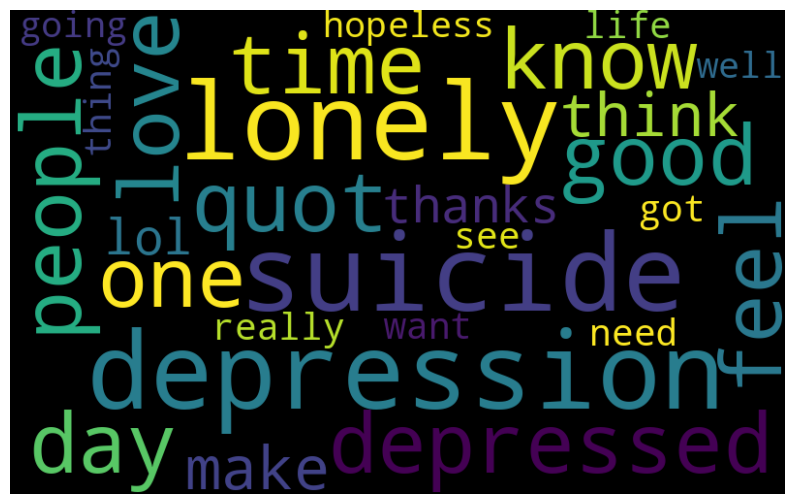

In [ ]:
"""
vocab = tfidf_vectorizer.get_feature_names_out()
word_scores = tfidf_matrix.sum(axis=0).A1
sorted_words = sorted(zip(vocab, word_scores), key=lambda x: x[1], reverse=True)
"""

vocab = count_vectorizer.get_feature_names_out()
word_scores = bow_matrix.sum(axis=0).A1
sorted_words = sorted(zip(vocab, word_scores), key=lambda x: x[1], reverse=True)

top_30_words = sorted_words[:30]

# Extraire les mots et les scores
words = [word for word, _ in top_30_words]
words = ', '.join(words)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Benchmark des algorithmes

Suite à des critères nous avons décidé d'appliquer les algorithmes suivants :

1.   Decision Tree
2.   Random Forest
3.   SVM
4.   AdaBoost
5.   LR
6.   Gradient Boosting
7.   KNN


*Division du jeu de données*

In [ ]:
#x = tfidf_matrix

x = bow_matrix

#Valeurs à prédire
y = np.array(tweet["label"])

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}

**Decision Tree**

In [ ]:
# Définir les hyperparamètres à tester
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 6]
}
dt_classifier = DecisionTreeClassifier()
dt_start_time = time.time()

# Effectuer la recherche d'hyperparamètres par validation croisée
grid_search_dt = GridSearchCV(dt_classifier, param_grid_dt, cv=5, scoring='f1')
grid_search_dt.fit(X_train, y_train)

# Meilleur modèle
best_dt_classifier = grid_search_dt.best_estimator_

# Obtenir les prédictions sur l'ensemble de test avec le meilleur modèle
y_pred_dt = best_dt_classifier.predict(X_test)

dt_end_time = time.time()
dt_execution_time = dt_end_time - dt_start_time

accuracy_dt = round(accuracy_score(y_test, y_pred_dt),2)
precision_dt = round(precision_score(y_test, y_pred_dt),2)
recall_dt = round(recall_score(y_test, y_pred_dt),2)
f1_dt = round(f1_score(y_test, y_pred_dt),2)


# Matrice de confusion
dt_confusion_mtx = confusion_matrix(y_test, y_pred_dt)
print("Matrice de confusion :")
print(dt_confusion_mtx)

Matrice de confusion :
[[8923    4]
 [ 945 7801]]


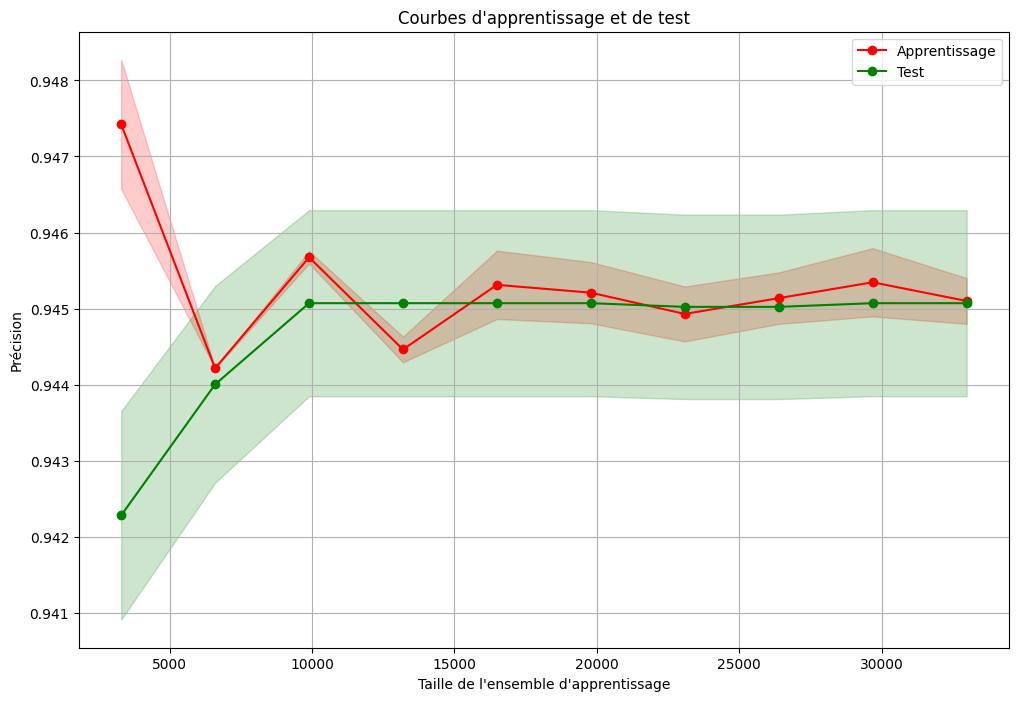

In [ ]:

from sklearn.model_selection import learning_curve
# Définir le modèle
model = grid_search_dt.best_estimator_

# Calculer les courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy'
)

# Calculer les moyennes et les écarts types des scores d'apprentissage et de test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracer les courbes d'apprentissage et de test
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Apprentissage')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Test')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='g')
plt.xlabel('Taille de l\'ensemble d\'apprentissage')
plt.ylabel('Précision')
plt.title('Courbes d\'apprentissage et de test')
plt.legend(loc='best')
plt.grid(True)
plt.show()


**Random Forest**

In [ ]:
param_grid_rf = {
    'n_estimators': [50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf_classifier = RandomForestClassifier()
rf_start_time = time.time()

grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring=scoring, refit='accuracy')
grid_search_rf.fit(X_train, y_train)

best_rf_classifier = grid_search_rf.best_estimator_

y_pred_rf = best_rf_classifier.predict(X_test)

rf_end_time = time.time()
rf_execution_time = rf_end_time - rf_start_time

accuracy_rf = round(accuracy_score(y_test, y_pred_rf),2)
precision_rf = round(precision_score(y_test, y_pred_rf),2)
recall_rf = round(recall_score(y_test, y_pred_rf),2)
f1_rf = round(f1_score(y_test, y_pred_rf),2)

rf_confusion_mtx = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :")
print(rf_confusion_mtx)


Matrice de confusion :
[[8711  216]
 [ 664 8082]]


**SVM**

In [ ]:
# Définir les hyperparamètres à tester
param_grid_svm = {
    'C': [0.1,1],
    'kernel': ['linear'],
    'gamma': [0.1,1]
}

svm_classifier = SVC()
svm_start_time = time.time()

grid_search_svm = GridSearchCV(svm_classifier, param_grid_svm, cv=5, scoring='f1')
grid_search_svm.fit(X_train, y_train)

best_svm_classifier = grid_search_svm.best_estimator_

y_pred_svm = best_svm_classifier.predict(X_test)

svm_end_time = time.time()
svm_execution_time = svm_end_time - svm_start_time

accuracy_svm = round(accuracy_score(y_test, y_pred_svm), 2)
precision_svm = round(precision_score(y_test, y_pred_svm, zero_division=1), 2)
recall_svm = round(recall_score(y_test, y_pred_svm), 2)
f1_svm = round(f1_score(y_test, y_pred_svm), 2)

svm_confusion_mtx = confusion_matrix(y_test, y_pred_svm)
print("Matrice de confusion :")
print(svm_confusion_mtx)

Matrice de confusion :
[[8741  186]
 [ 666 8080]]


**AdaBoost**

In [ ]:
param_grid_adaboost = {
    'n_estimators': [25, 50],
    'learning_rate': [0.1,0.25]
}

adaboost_classifier = AdaBoostClassifier()
adaboost_start_time = time.time()

grid_search_adaboost = GridSearchCV(adaboost_classifier, param_grid_adaboost, cv=5, scoring='f1')
grid_search_adaboost.fit(X_train, y_train)

best_adaboost_classifier = grid_search_adaboost.best_estimator_

y_pred_adaboost = best_adaboost_classifier.predict(X_test)

adaboost_end_time = time.time()
adaboost_execution_time = adaboost_end_time - adaboost_start_time

accuracy_adaboost = round(accuracy_score(y_test, y_pred_adaboost), 2)
precision_adaboost = round(precision_score(y_test, y_pred_adaboost), 2)
recall_adaboost = round(recall_score(y_test, y_pred_adaboost), 2)
f1_adaboost = round(f1_score(y_test, y_pred_adaboost), 2)

adaboost_confusion_mtx = confusion_matrix(y_test, y_pred_adaboost)
print("Matrice de confusion :")
print(adaboost_confusion_mtx)


Matrice de confusion :
[[8923    4]
 [ 944 7802]]


**Gradient Boosting**

In [ ]:
param_grid_gb = {
    'n_estimators': [25, 50],
    'learning_rate': [0.1,0.25]
}

gb_classifier = GradientBoostingClassifier()
gb_start_time = time.time()

grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, cv=5, scoring='f1')
grid_search_gb.fit(X_train, y_train)

best_gb_classifier = grid_search_gb.best_estimator_

y_pred_gb = best_gb_classifier.predict(X_test)

gb_end_time = time.time()
gb_execution_time = gb_end_time - gb_start_time

accuracy_gb = round(accuracy_score(y_test, y_pred_gb), 2)
precision_gb = round(precision_score(y_test, y_pred_gb), 2)
recall_gb = round(recall_score(y_test, y_pred_gb), 2)
f1_gb = round(f1_score(y_test, y_pred_gb), 2)

gb_confusion_mtx = confusion_matrix(y_test, y_pred_gb)
print("Matrice de confusion :")
print(gb_confusion_mtx)


Matrice de confusion :
[[8923    4]
 [ 912 7834]]


**Regréssion Logisitique**

In [ ]:
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

lr_classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_start_time = time.time()

grid_search_lr = GridSearchCV(lr_classifier, param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train, y_train)

best_lr_classifier = grid_search_lr.best_estimator_

y_pred_lr = best_lr_classifier.predict(X_test)

lr_end_time = time.time()
lr_execution_time = lr_end_time - lr_start_time

accuracy_lr = round(accuracy_score(y_test, y_pred_lr), 2)
precision_lr = round(precision_score(y_test, y_pred_lr), 2)
recall_lr = round(recall_score(y_test, y_pred_lr), 2)
f1_lr = round(f1_score(y_test, y_pred_lr), 2)

lr_confusion_mtx = confusion_matrix(y_test, y_pred_lr)
print("Matrice de confusion :")
print(lr_confusion_mtx)


Matrice de confusion :
[[8833   94]
 [ 719 8027]]


K Nearest Neightbors

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5],
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_classifier = KNeighborsClassifier()
knn_start_time = time.time()

grid_search_knn = GridSearchCV(knn_classifier, param_grid_knn, cv=5, scoring='f1')
grid_search_knn.fit(X_train, y_train)

best_knn_classifier = grid_search_knn.best_estimator_

y_pred_knn = best_knn_classifier.predict(X_test)

knn_end_time =time.time()
knn_execution_time = knn_end_time - knn_start_time

accuracy_knn = round(accuracy_score(y_test, y_pred_knn), 2)
precision_knn = round(precision_score(y_test, y_pred_knn), 2)
recall_knn = round(recall_score(y_test, y_pred_knn), 2)
f1_knn = round(f1_score(y_test, y_pred_knn), 2)

knn_confusion_mtx = confusion_matrix(y_test, y_pred_knn)
print("Matrice de confusion :")
print(knn_confusion_mtx)


Matrice de confusion :
[[8570  357]
 [1108 7638]]


**Evaluation des performances**

Pour cela nous avons calculé la performance de 4 métriques



1.  *Accuracy* : proportion de prédictions correctes par rapport à l'ensemble total des prédictions, il s'agit de la capacité d'un modèle à prédire correctement toutes les classes. Par exemple, une accuracy de 0,85 signifie que le modèle a correctement prédit 85 % des exemples.
2.  *Précision* : La précision mesure la proportion de prédictions positives correctes par rapport à l'ensemble total des prédictions positives. Elle évalue la capacité d'un modèle à minimiser les faux positifs. Par exemple, si la précision est de 0,90 pour une classe spécifique, cela signifie que 90 % des prédictions positives pour cette classe sont correctes.
3.  Recall : Le recall mesure la proportion de prédictions positives correctes par rapport à l'ensemble total des exemples réels positifs. Il évalue la capacité d'un modèle à minimiser les faux négatifs. Par exemple, si le recall est de 0,80 pour une classe spécifique, cela signifie que le modèle a correctement identifié 80 % des exemples réels positifs pour cette classe
4.  *F1 score* est une mesure qui combine à la fois la précision et le rappel d'un modèle en une seule valeur. Il permet d'évaluer l'équilibre entre la capacité à minimiser à la fois les faux positifs et les faux négatifs. Un F1 score élevé indique que le modèle a une bonne balance entre la précision et le rappel, ce qui est généralement souhaitable pour de nombreux problèmes de classification.



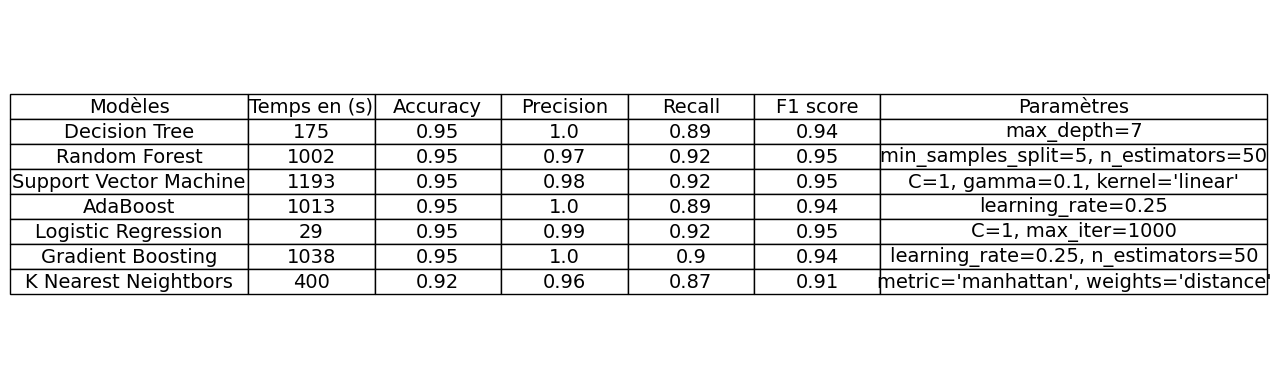

In [ ]:
# Conversion des temps d'exécutions des classficateurs

rf_execution_time_minutes = int(round(rf_execution_time, 0))
dt_execution_time_minutes = int(round(dt_execution_time, 0))
svm_execution_time_minutes = int(round(svm_execution_time, 0))
adaboost_execution_time_minutes = int(round(adaboost_execution_time, 0))
lr_execution_time_minutes = int(round(lr_execution_time, 0))
gb_execution_time_minutes = int(round(gb_execution_time, 0))
knn_execution_time_minutes = int(round(knn_execution_time, 0))

models = ['Decision Tree', 'Random Forest','Support Vector Machine', 'AdaBoost', 'Logistic Regression', 'Gradient Boosting','K Nearest Neightbors']
temps = [dt_execution_time_minutes, rf_execution_time_minutes, svm_execution_time_minutes, adaboost_execution_time_minutes, lr_execution_time_minutes, gb_execution_time_minutes, knn_execution_time_minutes]
precision_scores = [precision_dt, precision_rf,precision_svm, precision_adaboost, precision_lr, precision_gb, precision_knn]
recall_scores = [recall_dt, recall_rf,recall_svm, recall_adaboost, recall_lr, recall_gb, recall_knn]
f1_scores = [f1_dt, f1_rf,f1_svm, f1_adaboost, f1_lr, f1_gb,f1_knn]
accuracy_score = [accuracy_dt, accuracy_rf,accuracy_svm, accuracy_adaboost, accuracy_lr, accuracy_gb, accuracy_knn]
best_hyperparams = [str(best_dt_classifier).split("(")[1].split(")")[0],
                             str(best_rf_classifier).split("(")[1].split(")")[0],
                             str(best_svm_classifier).split("(")[1].split(")")[0],
                             str(best_adaboost_classifier).split("(")[1].split(")")[0],
                             str(best_lr_classifier).split("(")[1].split(")")[0],
                             str(best_gb_classifier).split("(")[1].split(")")[0],
                             str(best_knn_classifier).split("(")[1].split(")")[0]]
table_data = [['Modèles', 'Temps en (s)','Accuracy','Precision', 'Recall', 'F1 score', 'Paramètres']]
for i in range(len(models)):
    table_data.append([models[i], temps[i], accuracy_score[i],precision_scores[i], recall_scores[i], f1_scores[i], best_hyperparams[i]])

# Afficher le tableau récapitulatif
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', colWidths=[0.32,0.17, 0.17, 0.17, 0.17, 0.17, 0.52])
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.5)
plt.show()